In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import binarize
import matplotlib.pyplot as plt

In [2]:
# Minimal preprocessing
base = pd.read_csv("base_ML_dataset.csv")
metadata = base.iloc[:, -2:]
metadata = metadata.reset_index().rename(columns = {"index": "assay_id"})
metadata.loc[metadata.tissue_type == "T-cell", "tissue_type"] = "blood"
labels = base.pop("tissue_type")
data = base.iloc[:, :-1]
data.fillna(0, inplace = True)
data.head()
full_df = pd.concat([data, labels], axis = 1)
full_df = full_df[~full_df.tissue_type.isin(["trophoblast","prostate", "fetal kidney", "lung", "fibroblast", "/"])]
full_df.loc[full_df.tissue_type == "T-cell", ["tissue_type"]] = "blood"
labels = full_df.pop("tissue_type")
data = full_df
metadata = metadata.loc[metadata.index.isin(data.index),:]

## KEGG mapping (uniprot to pathway)

In [164]:
# uniprot_id in data
uniprot_id = pd.Series(data.columns, name = "uniprot_id")

# gene_id to uniprot_id
gene_uniprot = pd.read_csv("annotation_files/hsa-uniprot.txt", sep = "\t", names = ['gene_id', "uniprot_id"], 
        converters = {"gene_id": lambda x: x.split(":")[1], "uniprot_id": lambda x: x.split(":")[1]})

# gene_id to pathway_id
gene_path = pd.read_csv("annotation_files/pathway-hsa.txt", sep = "\t", names = ["path", "gene_id"],
        converters = {"gene_id": lambda x: x.split(":")[1], "path": lambda x: x.split(":")[1]})

# pathway_id to pathway_meta
path_meta = pd.read_csv("annotation_files/pathway-meta.txt", sep = "\t", names = ["path", "meta"],
        converters = {"path": lambda x: x.split(":")[1], "meta": lambda x: x.split("-")[0]})

# merge the dataframes
KEGG_MAP = pd.merge(left = uniprot_id, right = gene_uniprot, how = "left").dropna().merge(gene_path).merge(path_meta)

In [4]:
KEGG_MAP.head(3)

,uniprot_id,gene_id,path,meta
0,A0AVT1,55236,hsa04120,Ubiquitin mediated proteolysis
1,A1L167,134111,hsa04120,Ubiquitin mediated proteolysis
2,O00308,11060,hsa04120,Ubiquitin mediated proteolysis


In [5]:
KEGG_MAP.nunique()

uniprot_id    5536
gene_id       5573
path           352
meta           334
dtype: int64

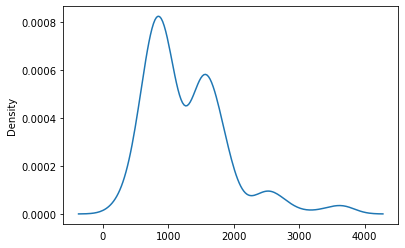

In [8]:
sns.kdeplot((data.loc[:, data.columns.isin(KEGG_MAP.uniprot_id.unique())] != 0).sum(axis = 1))

Change the features to pathway representation

In [9]:
# binarize the mapped uniprot ids
bool_data = data.loc[:, data.columns.isin(KEGG_MAP.uniprot_id.unique())] != 0
bool_data.head()

,A0AVT1,A0PJZ3,A1A4S6,A1L167,A1L188,A2RRD8,A2RTX5,A2RU49,A4D0S4,A4D126,...,Q9Y6R1,Q9Y6R4,Q9Y6R6,Q9Y6U3,Q9Y6V0,Q9Y6W5,Q9Y6W6,Q9Y6X2,Q9Y6X5,Q9Y6Y9
0,True,False,True,False,True,False,True,True,False,True,...,True,True,True,False,False,True,False,False,True,False
1,True,False,True,False,False,False,True,True,False,True,...,True,True,True,True,False,True,False,False,True,False
2,True,False,True,False,False,False,True,True,False,False,...,False,False,False,True,False,True,False,True,False,True
3,True,False,True,False,False,False,True,True,False,False,...,True,True,False,True,False,True,False,True,False,True
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [ ]:
def path_mapper(protein_id):
    return KEGG_MAP[KEGG_MAP.uniprot_id == protein_id].path.unique()

sample_entry = {key: 0 for key in KEGG_MAP.path.unique()}
dict_to_df_path = {key: [] for key in KEGG_MAP.path.unique()}
p_id_columns = bool_data.columns

for index, row in bool_data.iterrows():
    print(index)
    # initialize entry format
    entry = sample_entry.copy()
    # iterate over the rows of a sample
    for i, protein_id in enumerate(row):
        # add 1 to path if path is linked to the protein
        if protein_id:
            for path in path_mapper(p_id_columns[i]):
                entry[path] += 1
    
    # add as new sample
    for key, value in entry.items():
        dict_to_df_path[key].append(value)

path_df = pd.DataFrame(data = dict_to_df_path)

In [11]:
from sklearn.preprocessing import normalize

norm_path_df = pd.DataFrame(normalize(path_df), columns = path_df.columns)

In [12]:
norm_path_df.head()

,hsa04120,hsa00514,hsa05100,hsa04714,hsa05168,hsa00970,hsa00310,hsa01100,hsa04151,hsa04510,...,hsa04950,hsa00232,hsa03430,hsa03267,hsa00130,hsa00524,hsa00430,hsa00780,hsa00440,hsa03264
0,0.066647,0.014882,0.038823,0.102235,0.071823,0.027176,0.028471,0.602411,0.089941,0.066000,...,0.007765,0.001294,0.014235,0.001294,0.005176,0.001941,0.003235,0.001941,0.003235,0.000000
1,0.065170,0.013550,0.039360,0.100014,0.069042,0.027746,0.030327,0.601373,0.092271,0.066461,...,0.006453,0.000645,0.013550,0.001291,0.005162,0.001936,0.003872,0.001936,0.003226,0.000645
2,0.069882,0.014105,0.041032,0.103861,0.075011,0.026927,0.028850,0.591752,0.090398,0.072446,...,0.002564,0.000641,0.013463,0.000641,0.005770,0.002564,0.001282,0.001282,0.003206,0.000641
3,0.068209,0.014157,0.041183,0.104887,0.075287,0.027026,0.028313,0.595217,0.088156,0.068852,...,0.002574,0.001287,0.014157,0.000643,0.005791,0.001930,0.003217,0.001287,0.003217,0.000643
4,0.066667,0.012698,0.044444,0.079365,0.050794,0.044444,0.025397,0.504762,0.082540,0.060317,...,0.003175,0.000000,0.022222,0.000000,0.000000,0.003175,0.000000,0.000000,0.000000,0.000000


---

## Export pathway dataset

In [16]:
norm_path_df.to_csv("pathway_dataset.csv", index = False)

---

## T-SNE and PCA for pathway dataset

In [1]:
norm_path_df = pd.read_csv("pathway_dataset.csv")

NameError: name 'pd' is not defined

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_path_df = scaler.fit_transform(norm_path_df)

In [8]:
from sklearn.manifold import TSNE

In [10]:
metadata = metadata.reset_index(drop = True)

In [16]:
full_df

,PXD_accession,TSNE1,TSNE2,assay_id,tissue_type
0,NaN,7.115507,-22.457848,NaN,NaN
1,NaN,7.097040,-22.776783,NaN,NaN
2,NaN,7.883793,-22.795286,NaN,NaN
3,NaN,7.678982,-22.708138,NaN,NaN
4,NaN,-14.720727,35.777542,NaN,NaN
...,...,...,...,...,...
423,PXD005940,NaN,NaN,505.0,ovary
424,PXD005940,NaN,NaN,506.0,skin
425,PXD005940,NaN,NaN,507.0,breast
426,PXD005940,NaN,NaN,508.0,blood


In [19]:
full_df

,TSNE1,TSNE2,assay_id,tissue_type,PXD_accession
0,12.021696,-19.323462,0,liver,PXD000533
1,12.270067,-19.540819,1,liver,PXD000533
2,11.732006,-20.114019,2,liver,PXD000533
3,11.815440,-19.910551,3,liver,PXD000533
4,-15.998687,35.478859,4,blood,PXD004280
...,...,...,...,...,...
423,11.993430,-8.500890,505,ovary,PXD005940
424,10.938141,-8.455744,506,skin,PXD005940
425,1.979582,-3.612846,507,breast,PXD005940
426,11.260905,-6.199917,508,blood,PXD005940


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


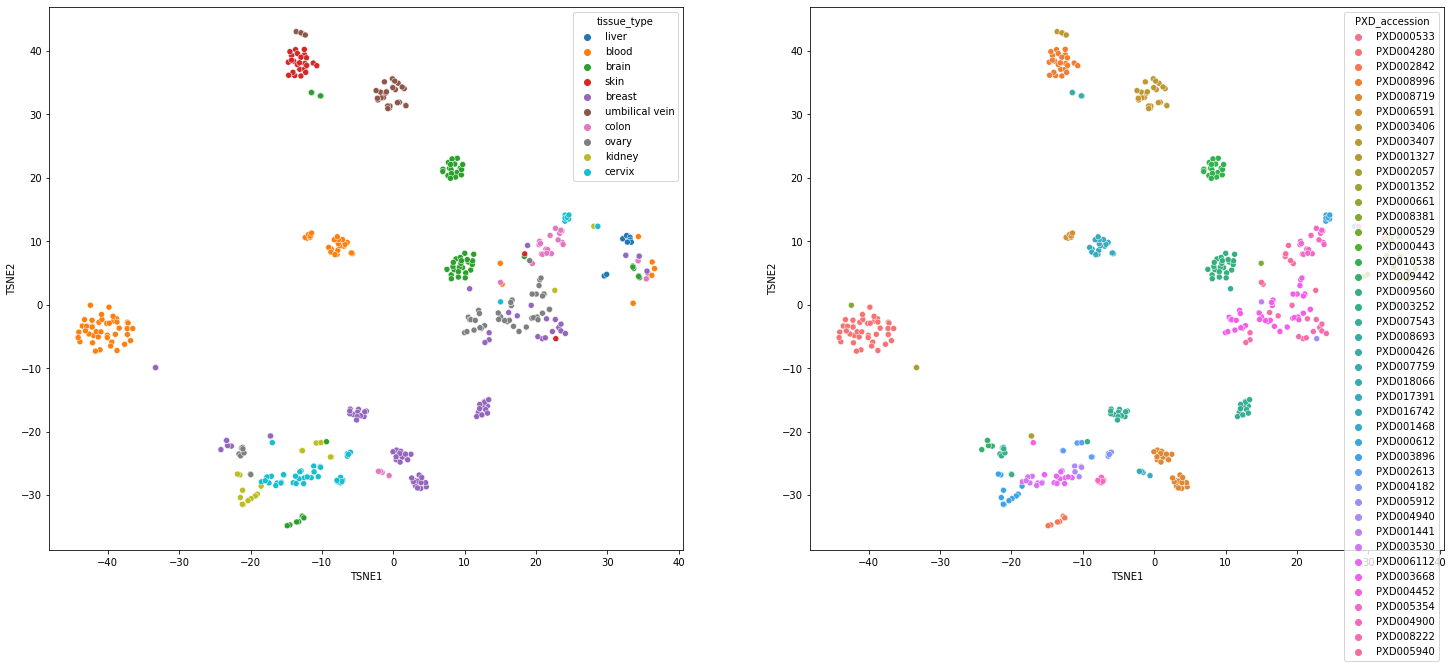

In [11]:
X_embedded = TSNE(perplexity = 20).fit_transform(norm_path_df)

X_embedded = pd.DataFrame(X_embedded, columns = ["TSNE1", "TSNE2"])
full_df = pd.concat([X_embedded, metadata], axis = 1)

fig, ax = plt.subplots(1,2, figsize = (25,10))
sns.scatterplot(data= full_df, x = "TSNE1", y = "TSNE2", hue = "tissue_type", ax = ax[0])
sns.scatterplot(data= full_df, x = "TSNE1", y = "TSNE2", hue = "PXD_accession", ax = ax[1])

---

# KEGG Feature Selection

Multiple feature selection options are available in different frameworks

In [3]:
norm_path_df = pd.read_csv("pathway_dataset.csv")

Text(0.5, 0, 'Percentage')

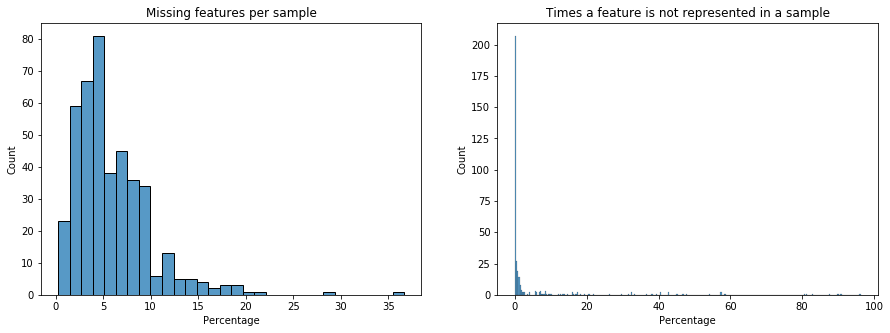

In [58]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.histplot((norm_path_df == 0).sum(axis = 1)/norm_path_df.shape[1] *100, ax = ax[0])
sns.histplot((norm_path_df == 0).sum(axis = 0)/norm_path_df.shape[0] *100, ax = ax[1])
ax[0].set_title("Missing features per sample")
ax[1].set_title("Times a feature is not represented in a sample")
ax[0].set_xlabel("Percentage")
ax[1].set_xlabel("Percentage")

In [71]:
# Check protein identifications for the 2 outlier datapoints

metadata[(norm_path_df == 0).sum(axis = 1)/norm_path_df.shape[1] *100 > 25]
print((data.iloc[[47,380],:] != 0).sum(axis=1))

47     317
380    339
dtype: int64


In [78]:
# Pathways represented in less than 50% of the samples
low_ab_f = norm_path_df.columns[(norm_path_df == 0).sum(axis = 0)/norm_path_df.shape[0] *100 > 50]
KEGG_MAP[KEGG_MAP.path.isin(low_ab_f)].meta.unique()

array(['Lipoic acid metabolism ', 'Nicotine addiction ', 'Virion ',
       'Linoleic acid metabolism ',
       'Intestinal immune network for IgA production ',
       'Autoimmune thyroid disease ', 'Graft', 'Allograft rejection ',
       'Asthma ', 'Caffeine metabolism ',
       'Phosphonate and phosphinate metabolism '], dtype=object)

Maybe split the pathway terms to their respective categories. These categories consist of the following: <br>
1. Metabolism
2. Genetic Information Processing
3. Environmental Information Processing
4. Cellular Processes
5. Organismal Systems
6. Human Diseases
7. Drug Development

In [6]:
scaled_path_df = pd.DataFrame(scaled_path_df, columns = norm_path_df.columns)

In [9]:
scaled_path_df.shape

(428, 352)

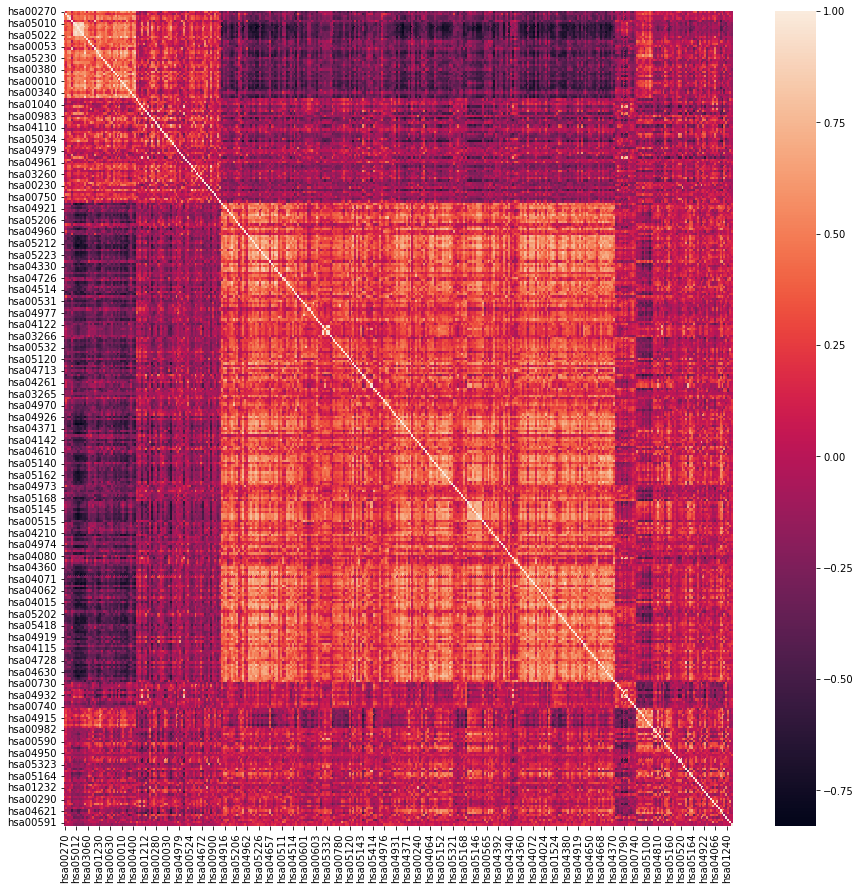

In [7]:
# Reference: https://wil.yegelwel.com/cluster-correlation-matrix/
import scipy
import scipy.cluster.hierarchy as sch
import numpy as np

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

plt.figure(figsize=(15,15))
sns.heatmap(cluster_corr(minmax_df.corr()))

There are some very large correlations that could be used to reduce the feature space

In [22]:
scaled_path_df.corr()

,hsa04120,hsa00514,hsa05100,hsa04714,hsa05168,hsa00970,hsa00310,hsa01100,hsa04151,hsa04510,...,hsa04950,hsa00232,hsa03430,hsa03267,hsa00130,hsa00524,hsa00430,hsa00780,hsa00440,hsa03264
hsa04120,1.000000,0.229613,-0.284896,-0.048617,0.531972,-0.214355,0.232023,0.380055,0.281571,0.128983,...,0.016494,0.051522,-0.111987,0.162719,0.386665,-0.170300,0.278215,0.305743,0.224262,0.104988
hsa00514,0.229613,1.000000,-0.405656,0.320883,0.200755,-0.535720,0.200622,0.532954,0.096999,0.198128,...,-0.066783,0.050855,-0.115087,0.282102,0.183212,-0.157955,0.305470,0.295437,0.004687,0.100047
hsa05100,-0.284896,-0.405656,1.000000,-0.609481,-0.250670,0.413198,-0.280756,-0.566529,0.296095,0.363132,...,0.098521,0.013027,-0.023447,-0.341735,-0.301376,0.087076,-0.250308,-0.332453,-0.184043,-0.068153
hsa04714,-0.048617,0.320883,-0.609481,1.000000,-0.014450,-0.529364,0.146619,0.351604,-0.464043,-0.422983,...,-0.275474,-0.066383,-0.044713,0.466119,0.290819,-0.201181,0.132793,0.330697,0.057920,-0.017588
hsa05168,0.531972,0.200755,-0.250670,-0.014450,1.000000,-0.370988,0.180731,0.323843,0.336532,0.225923,...,0.083662,0.198872,-0.336585,0.095738,0.402455,-0.108476,0.318779,0.391991,0.459501,0.184475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa00524,-0.170300,-0.157955,0.087076,-0.201181,-0.108476,0.292515,-0.044581,-0.186643,-0.166405,-0.128831,...,-0.017690,-0.104243,0.088944,-0.248834,-0.193764,1.000000,-0.197725,-0.219448,-0.079708,0.066398
hsa00430,0.278215,0.305470,-0.250308,0.132793,0.318779,-0.331917,0.198396,0.389995,0.188232,0.211912,...,-0.103640,0.068449,-0.330458,0.315439,0.344000,-0.197725,1.000000,0.263653,0.144943,0.068856
hsa00780,0.305743,0.295437,-0.332453,0.330697,0.391991,-0.458555,0.194792,0.423937,0.155057,0.088257,...,0.021463,0.114354,-0.294597,0.339337,0.441638,-0.219448,0.263653,1.000000,0.137574,0.112210
hsa00440,0.224262,0.004687,-0.184043,0.057920,0.459501,-0.166315,0.229772,0.327765,0.082086,0.013091,...,0.017673,0.106569,-0.041900,-0.116936,0.499063,-0.079708,0.144943,0.137574,1.000000,0.112395


In [44]:
corred_df = cluster_corr(scaled_path_df.corr())
path_ids = corred_df.columns
correlators = {}

counter = 0
for index, row in corred_df.iterrows():
    correlators[index] = []
    for i, correlator in enumerate(row):
        if i > counter:
            if abs(correlator) > 0.80:
                correlators[index] += [path_ids[i]]
    counter+=1

In [50]:
counter = []
keys = []
for key, values in correlators.items():
    if values != []:
        counter += values
        keys.append(key)
print(len(set(counter)), len(keys))

57 55


## Overview feature selectors:

1. **Based on univariate statistics**
    - chi2 (are the features randomly distributed across classes?)
    - pearson correlation (drop highly-correlated columns)
    - Mutual information (Also considers non-linear dependencies)
    - ANOVA F-values (linear dependencies)

2. **Based on feature importance of ML models**
    - L1 for LinearSVC, LogisticRegression
    - ExtraTreesClassifier: based on impurity
    - Select highest weights in PCA components
    - Based on SHAP-values (reference: https://github.com/manuel-calzolari/shapicant)
    - Utilizing LIME to explain predictions (reference: https://medium.com/dataman-in-ai/explain-your-model-with-lime-5a1a5867b423)

3. **Iterative addition**
    - Forward
    - Backward


# Univariate statistics - An Explorative Comparison

In [14]:
norm_path_df.head(6)

,hsa04120,hsa00514,hsa05100,hsa04714,hsa05168,hsa00970,hsa00310,hsa01100,hsa04151,hsa04510,...,hsa04950,hsa00232,hsa03430,hsa03267,hsa00130,hsa00524,hsa00430,hsa00780,hsa00440,hsa03264
0,0.066647,0.014882,0.038823,0.102235,0.071823,0.027176,0.028471,0.602411,0.089941,0.066000,...,0.007765,0.001294,0.014235,0.001294,0.005176,0.001941,0.003235,0.001941,0.003235,0.000000
1,0.065170,0.013550,0.039360,0.100014,0.069042,0.027746,0.030327,0.601373,0.092271,0.066461,...,0.006453,0.000645,0.013550,0.001291,0.005162,0.001936,0.003872,0.001936,0.003226,0.000645
2,0.069882,0.014105,0.041032,0.103861,0.075011,0.026927,0.028850,0.591752,0.090398,0.072446,...,0.002564,0.000641,0.013463,0.000641,0.005770,0.002564,0.001282,0.001282,0.003206,0.000641
3,0.068209,0.014157,0.041183,0.104887,0.075287,0.027026,0.028313,0.595217,0.088156,0.068852,...,0.002574,0.001287,0.014157,0.000643,0.005791,0.001930,0.003217,0.001287,0.003217,0.000643
4,0.066667,0.012698,0.044444,0.079365,0.050794,0.044444,0.025397,0.504762,0.082540,0.060317,...,0.003175,0.000000,0.022222,0.000000,0.000000,0.003175,0.000000,0.000000,0.000000,0.000000
5,0.054803,0.015223,0.045669,0.088293,0.048714,0.048714,0.024357,0.499314,0.079159,0.045669,...,0.003045,0.000000,0.024357,0.000000,0.000000,0.003045,0.000000,0.000000,0.000000,0.000000


In [158]:
norm_path_df.describe()

,hsa04120,hsa00514,hsa05100,hsa04714,hsa05168,hsa00970,hsa00310,hsa01100,hsa04151,hsa04510,...,hsa04950,hsa00232,hsa03430,hsa03267,hsa00130,hsa00524,hsa00430,hsa00780,hsa00440,hsa03264
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,...,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,0.055077,0.015503,0.045705,0.108154,0.052664,0.035106,0.025412,0.554038,0.079638,0.067645,...,0.001685,0.000301,0.015622,0.001462,0.001537,0.002861,0.001316,0.001104,0.000445,0.000045
std,0.012273,0.005104,0.008273,0.019269,0.012288,0.007217,0.005739,0.035006,0.013247,0.014377,...,0.001518,0.000698,0.004895,0.001375,0.001679,0.001430,0.001324,0.001172,0.001009,0.000238
min,0.009174,0.000000,0.009174,0.030221,0.010176,0.020062,0.009174,0.390848,0.031286,0.018347,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.049538,0.012722,0.041177,0.097910,0.045581,0.030212,0.021620,0.536587,0.072116,0.058845,...,0.000000,0.000000,0.013016,0.000000,0.000000,0.002016,0.000000,0.000000,0.000000,0.000000
50%,0.056638,0.015500,0.044685,0.112925,0.051670,0.033099,0.024888,0.559622,0.079320,0.066772,...,0.001502,0.000000,0.015096,0.001415,0.001366,0.002611,0.001349,0.001285,0.000000,0.000000
75%,0.062882,0.018612,0.049167,0.121225,0.058928,0.038737,0.028061,0.575910,0.088576,0.076021,...,0.002734,0.000000,0.018746,0.002568,0.002629,0.003485,0.002445,0.002120,0.000000,0.000000
max,0.089707,0.030506,0.094979,0.165124,0.122879,0.069076,0.047797,0.641014,0.119079,0.119079,...,0.007765,0.004677,0.040862,0.004821,0.007243,0.010338,0.005282,0.004394,0.005183,0.001516


In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
scaled_path_df = pd.DataFrame(scaler.fit_transform(norm_path_df), columns = norm_path_df.columns)
minmax_df = pd.DataFrame(minmax_scaler.fit_transform(norm_path_df), columns = norm_path_df.columns)
scaled_path_df.head(6)

,hsa04120,hsa00514,hsa05100,hsa04714,hsa05168,hsa00970,hsa00310,hsa01100,hsa04151,hsa04510,...,hsa04950,hsa00232,hsa03430,hsa03267,hsa00130,hsa00524,hsa00430,hsa00780,hsa00440,hsa03264
0,0.943861,-0.121732,-0.832720,-0.307540,1.560977,-1.099993,0.533616,1.383452,0.778662,-0.114566,...,4.010099,1.426105,-0.283578,-0.122141,2.169887,-0.643771,1.450798,0.715265,2.768767,-0.187632
1,0.823400,-0.383044,-0.767762,-0.422956,1.334344,-1.021015,0.857440,1.353778,0.954740,-0.082472,...,3.144556,0.494794,-0.423685,-0.124773,2.161265,-0.647567,1.931732,0.710631,2.759799,2.521078
2,1.207753,-0.274299,-0.565517,-0.223058,1.820669,-1.134599,0.599869,1.078613,0.813172,0.334343,...,0.579944,0.488863,-0.441434,-0.597646,2.523811,-0.207398,-0.025579,0.152236,2.739298,2.503731
3,1.071255,-0.264117,-0.547245,-0.169765,1.843159,-1.120853,0.506134,1.177700,0.643783,0.084051,...,0.586169,1.415827,-0.299689,-0.595928,2.536471,-0.651291,1.437265,0.156268,2.751003,2.513636
4,0.945470,-0.550149,-0.152519,-1.495811,-0.152413,1.295417,-0.002602,-1.409270,0.219285,-0.510271,...,0.982397,-0.431328,1.350001,-1.064500,-0.916487,0.219755,-0.994864,-0.943369,-0.441575,-0.187632
5,-0.022343,-0.054907,-0.004343,-1.031925,-0.321890,1.887620,-0.184045,-1.565090,-0.036184,-1.530346,...,0.896641,-0.431328,1.786581,-1.064500,-0.916487,0.128736,-0.994864,-0.943369,-0.441575,-0.187632


In [6]:
target_encoder = LabelEncoder()

y = target_encoder.fit_transform(metadata.tissue_type)

In [7]:
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [17]:
chi2_features = SelectKBest(chi2, k = 50).fit(minmax_df, y)
f_classif_features = SelectKBest(f_classif, k = 50).fit(minmax_df, y)
mi_features = SelectKBest(mutual_info_classif, k = 50).fit(minmax_df, y)

# Parsing
MI_f = pd.Series(mi_features.scores_, index = norm_path_df.columns).reset_index(name = "MI").rename(columns = {"index":"path_id"}).sort_values(by = "MI", ascending = False).reset_index()
f_features = pd.Series(f_classif_features.scores_, index = norm_path_df.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
chi2_scores = pd.Series(chi2_features.scores_, index = norm_path_df.columns).reset_index(name = "chi2_scores").rename(columns = {"index":"path_id"}).sort_values(by = "chi2_scores", ascending = False).reset_index()

In [13]:
estimator_svc = SVC(kernel="linear")
selector_svc = RFE(estimator_svc, n_features_to_select=50, step=10)
selector_svc = selector_svc.fit(minmax_df, y)

selector_lr = RFE(LogisticRegression(penalty="l1", solver = "liblinear", multi_class="ovr"), n_features_to_select=50, step = 10)
selector_lr = selector_lr.fit(minmax_df, y)

In [44]:
lr_f = pd.Series(selector_lr.get_support(), index = minmax_df.columns).reset_index(name = "LR").rename(columns = {"index":"path_id"})
lr_f = lr_f[lr_f.LR]
svc_f = pd.Series(selector_svc.get_support(), index = minmax_df.columns).reset_index(name = "SVC").rename(columns = {"index":"path_id"})
svc_f = svc_f[svc_f.SVC]

In [47]:
# Coloring the plot

top_MI = MI_f.iloc[:50,:] 
top_f = f_features.iloc[:50,:]
top_chi2 = chi2_scores.iloc[:50,:]

def color_parser(counts):
    if counts > 3:
        return 'darkgreen'
    if counts == 3:
        return 'tab:green'
    if counts == 2:
        return "tab:orange"
    if counts == 1:
        return 'tab:red'
    raise Exception

def count_paths(obj1, list_of_obj):
    colors = []
    for path in obj1.tolist():
        count = 1
        for objx in list_of_obj:
            if path in objx.tolist():
                count+=1
        colors.append(color_parser(count))
    return colors
        
MI_objects = [top_f.path_id, top_chi2.path_id, svc_f.path_id, lr_f.path_id]
F_objects = [top_MI.path_id, top_chi2.path_id, svc_f.path_id, lr_f.path_id]
chi2_objects = [top_f.path_id, top_MI.path_id, svc_f.path_id, lr_f.path_id]

MI_colors = count_paths(top_MI.path_id, MI_objects)
f_colors = count_paths(top_f.path_id, F_objects)
chi2_colors = count_paths(top_chi2.path_id, chi2_objects)

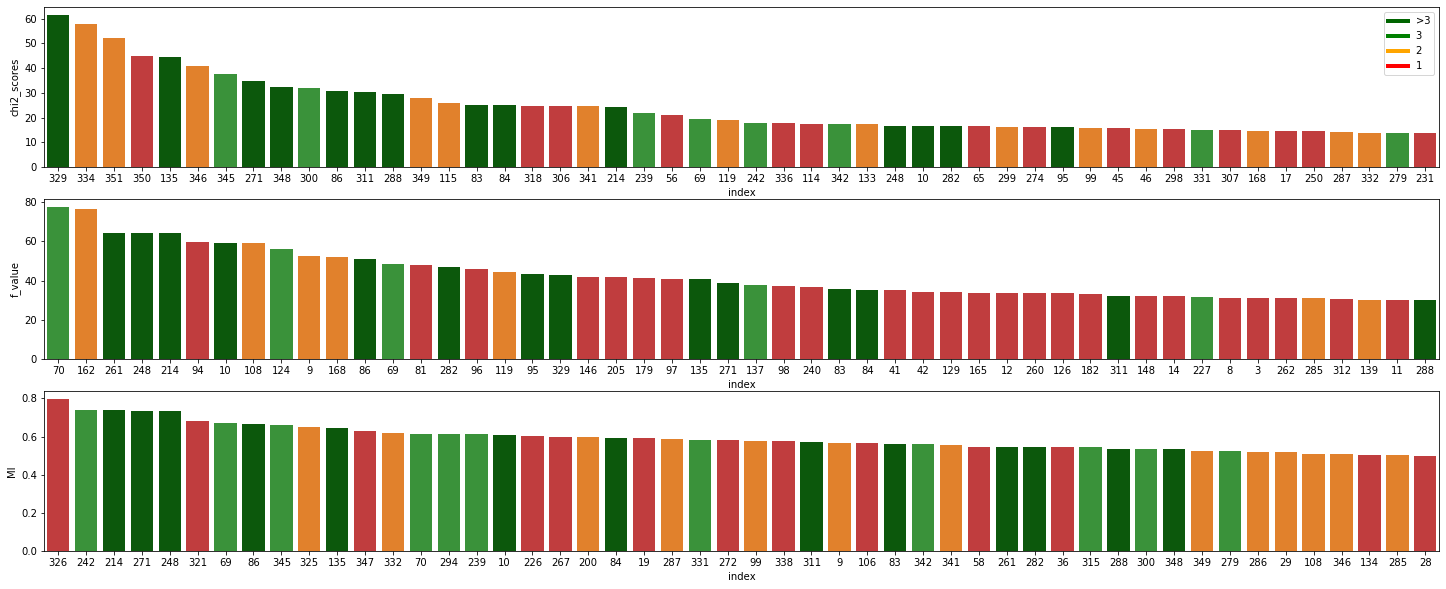

<Figure size 1800x432 with 0 Axes>

In [49]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(3,1, figsize= (25,10))
plt.figure(figsize = (25, 6))
sns.barplot(x = top_chi2["index"], y = top_chi2.chi2_scores, order = top_chi2["index"], ax = ax[0], palette = chi2_colors)
sns.barplot(x = top_f["index"], y = top_f.f_value, order = top_f["index"], ax = ax[1], palette = f_colors)
sns.barplot(x = top_MI["index"], y = top_MI.MI, order = top_MI["index"], ax = ax[2], palette = MI_colors)

custom_lines = [Line2D([0], [0], color="darkgreen", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color ="orange", lw = 4),
                Line2D([0], [0], color="red", lw=4)]


ax[0].legend(custom_lines, [">3","3", "2", "1"])


In [51]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

weights = {}
all = metadata.tissue_type.value_counts().sum()
for index, row in metadata.tissue_type.value_counts().reset_index().iterrows():
    weights[row["index"]] = all/(metadata.tissue_type.nunique()*row["tissue_type"])

print(weights)

svc = SVC(class_weight=weights)
lr = LogisticRegression(class_weight=weights)
rf = RandomForestClassifier(class_weight = weights)

{'breast': 0.5156626506024097, 'blood': 0.5706666666666667, 'brain': 0.6793650793650794, 'ovary': 0.8734693877551021, 'cervix': 0.9106382978723404, 'umbilical vein': 1.5285714285714285, 'skin': 1.646153846153846, 'colon': 1.646153846153846, 'kidney': 2.14, 'liver': 3.890909090909091}


**NOTE! This workflow has data leakage as the test and train sets are both used to fit the scaler**

In [ ]:
# No feature selection performance --> performance is better (0.91)
grid_clf = GridSearchCV(lr, param_grid={"C": [0.005,0.05,0.5,1,3], "multi_class": ["ovr"]}, scoring="f1_micro", verbose = 0)
cv_score = cross_val_score(grid_clf, minmax_df, metadata.tissue_type, scoring = "f1_micro", cv = 10)
cv_score_shuffle = cross_val_score(grid_clf, minmax_df.sample(frac = 1, random_state=1).reset_index(drop = True), metadata.tissue_type, scoring = "f1_micro", cv = 10)
print(f"F (mean,std, shuffle):    {cv_score.mean(), cv_score.std()}\t{cv_score_shuffle.mean()}")

In [170]:
grid_clf = GridSearchCV(svc, param_grid={"C": [0.005,0.05,0.5,1,3]}, scoring="f1_micro")
grid_clf2 = GridSearchCV(lr, param_grid={"C": [0.005,0.05,0.5,1,3], "multi_class": ["ovr"]}, scoring="f1_micro")
grid_clf3 = GridSearchCV(rf, param_grid={"min_impurity_decrease": [0,0.005,0.05,0.01,0.1,0.2]}, scoring="f1_micro")

flag = True
for estimator in [grid_clf, grid_clf2, grid_clf3]:
    chi2_model_score = cross_val_score(estimator, minmax_df.loc[:,chi2_features.get_support()], metadata.tissue_type, scoring = "f1_micro", cv = 10)
    mi_model_score = cross_val_score(estimator, minmax_df.loc[:,mi_features.get_support()], metadata.tissue_type, scoring = "f1_micro", cv = 10)
    f_model_score = cross_val_score(estimator, minmax_df.loc[:,f_classif_features.get_support()], metadata.tissue_type, scoring = "f1_micro", cv = 10)

    chi2_model_score_shuffle = cross_val_score(estimator, minmax_df.loc[:,chi2_features.get_support()].sample(frac = 1, random_state=1).reset_index(drop = True), metadata.tissue_type, scoring = "f1_micro", cv = 10)
    mi_model_score_shuffle = cross_val_score(estimator, minmax_df.loc[:,mi_features.get_support()].sample(frac = 1, random_state=1).reset_index(drop = True), metadata.tissue_type, scoring = "f1_micro", cv = 10)
    f_model_score_shuffle = cross_val_score(estimator, minmax_df.loc[:,f_classif_features.get_support()].sample(frac = 1, random_state=1).reset_index(drop = True), metadata.tissue_type, scoring = "f1_micro", cv = 10)


    print("\n{}".format(type(estimator.estimator).__name__))
    print(f"Chi2 (mean,std, control): {chi2_model_score.mean(), chi2_model_score.std()}\t{chi2_model_score_shuffle.mean()}")
    print(f"MI (mean,std, control):   {mi_model_score.mean(), mi_model_score.std()}\t{mi_model_score_shuffle.mean()}")
    print(f"F (mean,std, control):    {f_model_score.mean(), f_model_score.std()}\t{f_model_score_shuffle.mean()}")


SVC
Chi2 (mean,std, control): (0.8639534883720928, 0.10110325012416768)	[0.09302326 0.09302326 0.04651163 0.09302326 0.06976744 0.09302326
 0.09302326 0.1627907  0.0952381  0.14285714]
MI (mean,std, control):   (0.8894795127353265, 0.10199515908094682)	[0.04651163 0.13953488 0.09302326 0.09302326 0.04651163 0.09302326
 0.18604651 0.11627907 0.16666667 0.07142857]
F (mean,std, control):    (0.8870985603543742, 0.10913857239754607)	[0.02325581 0.09302326 0.06976744 0.09302326 0.09302326 0.13953488
 0.20930233 0.06976744 0.04761905 0.11904762]

LogisticRegression
Chi2 (mean,std, control): (0.8241971207087486, 0.13128021634750298)	[0.11627907 0.11627907 0.06976744 0.09302326 0.18604651 0.09302326
 0.04651163 0.11627907 0.0952381  0.0952381 ]
MI (mean,std, control):   (0.8521040974529346, 0.12448659849767034)	[0.11627907 0.06976744 0.06976744 0.18604651 0.04651163 0.04651163
 0.04651163 0.06976744 0.11904762 0.07142857]
F (mean,std, control):    (0.8357696566998893, 0.11746460970635902)	[0

TODO:
- Compare SelectFromModel
- Create pipeline that makes scaling more valid (splitting test and train)
- Explore SHAP and LIME
- Split pathway features and create a model for each group. Then aggregate the prediction with a weighted voting classifier
- Finally: Extract feature importance per class and store these pathways to compare with GSEA on feature importance of protein expression models

# A pipeline for KEGG-based tissue type prediction

In [8]:
df = pd.read_csv("pathway_dataset.csv")

In [61]:
(df == 0).sum(axis = 1)

0       3
1       2
2       3
3       2
4      34
       ..
423     8
424    11
425    11
426     9
427    22
Length: 428, dtype: int64

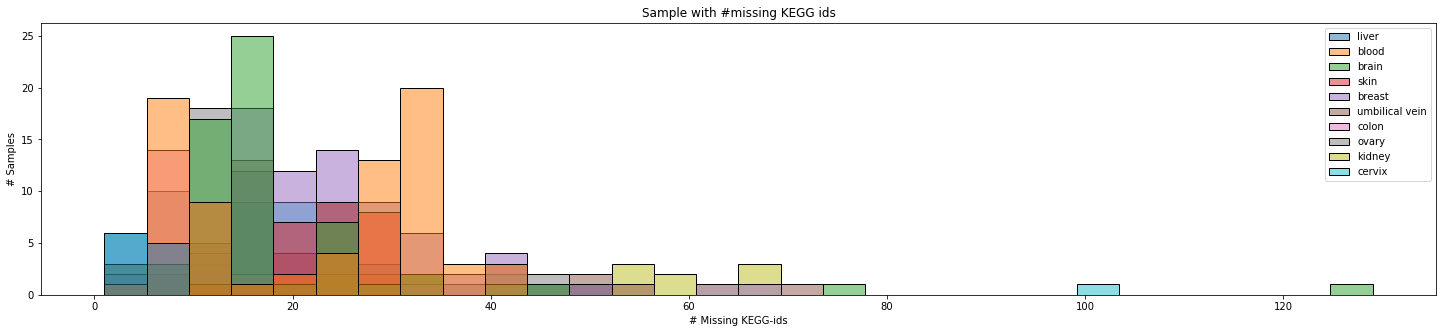

In [11]:
plt.figure(figsize = (25,5))
plt.title("Sample with #missing KEGG ids")
plt.xlabel("# Missing KEGG-ids")
plt.ylabel("# Samples")
sns.histplot(x=(df == 0).sum(axis = 1), hue = target_encoder.inverse_transform(y))

Kidney and a certain brain and cervix sample has more missing values than the others

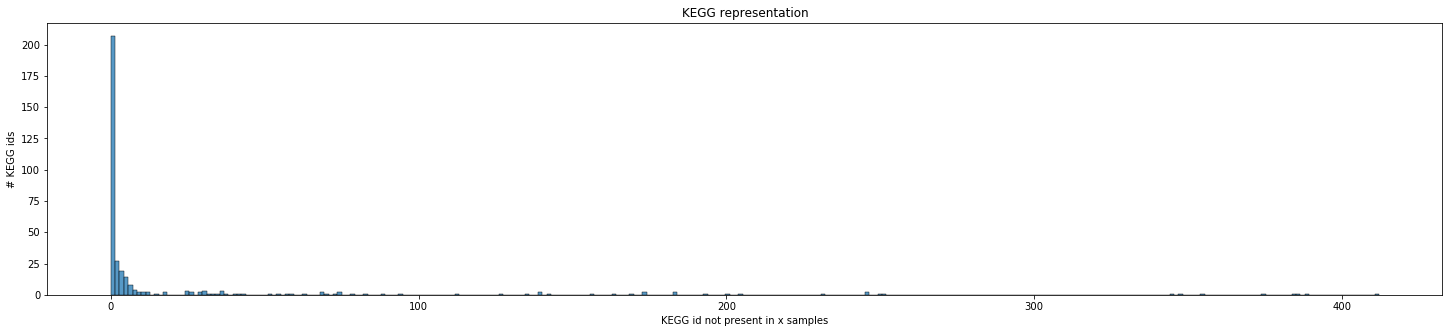

In [90]:
plt.figure(figsize = (25,5))
plt.title("KEGG representation")
plt.ylabel("# KEGG ids")
plt.xlabel("KEGG id not present in x samples")
sns.histplot(x = (df == 0).sum(axis = 0))

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


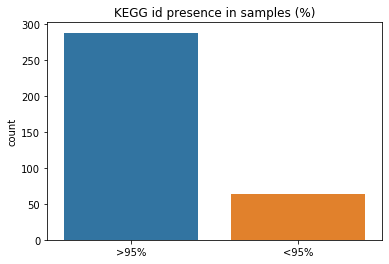

In [86]:
sample_hsa_counts = (df != 0).sum(axis = 0)/df.shape[0] > 0.95
sample_hsa_counts.replace(True, ">95%", inplace = True)
sample_hsa_counts.replace(False, "<95%", inplace = True)
plt.title("KEGG id presence in samples (%)")
sns.countplot(sample_hsa_counts)

Pipeline will include the following: 
- MinMax Scaler
- Majority vote-based feature selector
- Ensemble model

In [87]:
df

,hsa04120,hsa00514,hsa05100,hsa04714,hsa05168,hsa00970,hsa00310,hsa01100,hsa04151,hsa04510,...,hsa04950,hsa00232,hsa03430,hsa03267,hsa00130,hsa00524,hsa00430,hsa00780,hsa00440,hsa03264
0,0.066647,0.014882,0.038823,0.102235,0.071823,0.027176,0.028471,0.602411,0.089941,0.066000,...,0.007765,0.001294,0.014235,0.001294,0.005176,0.001941,0.003235,0.001941,0.003235,0.000000
1,0.065170,0.013550,0.039360,0.100014,0.069042,0.027746,0.030327,0.601373,0.092271,0.066461,...,0.006453,0.000645,0.013550,0.001291,0.005162,0.001936,0.003872,0.001936,0.003226,0.000645
2,0.069882,0.014105,0.041032,0.103861,0.075011,0.026927,0.028850,0.591752,0.090398,0.072446,...,0.002564,0.000641,0.013463,0.000641,0.005770,0.002564,0.001282,0.001282,0.003206,0.000641
3,0.068209,0.014157,0.041183,0.104887,0.075287,0.027026,0.028313,0.595217,0.088156,0.068852,...,0.002574,0.001287,0.014157,0.000643,0.005791,0.001930,0.003217,0.001287,0.003217,0.000643
4,0.066667,0.012698,0.044444,0.079365,0.050794,0.044444,0.025397,0.504762,0.082540,0.060317,...,0.003175,0.000000,0.022222,0.000000,0.000000,0.003175,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.052639,0.025645,0.047240,0.107977,0.045890,0.029694,0.021595,0.624919,0.079633,0.080983,...,0.002699,0.000000,0.008098,0.002699,0.002699,0.002699,0.001350,0.001350,0.000000,0.000000
424,0.069261,0.021804,0.043609,0.111587,0.056435,0.028217,0.016674,0.587434,0.089782,0.066696,...,0.003848,0.000000,0.015391,0.001283,0.003848,0.002565,0.002565,0.002565,0.000000,0.000000
425,0.064826,0.024827,0.042758,0.133790,0.056551,0.027586,0.023448,0.595850,0.086895,0.062068,...,0.002759,0.000000,0.012414,0.001379,0.004138,0.004138,0.001379,0.001379,0.000000,0.000000
426,0.075157,0.015658,0.042276,0.134656,0.053236,0.029750,0.021921,0.554281,0.079854,0.065762,...,0.000000,0.000000,0.017223,0.001566,0.003132,0.004697,0.001566,0.001566,0.001566,0.000000


In [95]:
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Scales features to values between 0 and 1
# NOTE: Exagerates pathway representation differences. Example: If all pathways are represented between 6 and 7 %, 6 and 7 % will be stretched to 0 and 100%
scaler = MinMaxScaler()

# Feature importance selection --> ensemble
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_features = 100, threshold = 0.5):
        self.num_features = num_features
        self.threshold = threshold
        

    def fit(self, X, y = None):
        
        scaled_X = MinMaxScaler().fit_transform(X)

        selector1 = SelectKBest(f_classif, k = self.num_features)
        selector2 = SelectKBest(mutual_info_classif, k = self.num_features)
        selector_svc = RFE(SVC(class_weight="balanced", kernel = "linear"), n_features_to_select=50, step=10)
        selector_lr = SelectFromModel(LogisticRegression(penalty="l1", solver = "liblinear", multi_class="ovr"), max_features=100)
        
        selectors = [selector1, selector2, selector_svc, selector_lr]
        supports = []
        for selector in selectors:
            selector.fit(scaled_X,y)
            supports.append(selector.get_support())
        
        votes = np.sum(supports, axis = 0)/len(selectors)
        final_mask = votes >= self.threshold
        self.final_mask = final_mask

        print(f"Selected {sum(final_mask)} features.")
        return self

    def transform(self, X, y = None):
        return pd.DataFrame(X).loc[:,self.final_mask]

feature_selection = FeatureSelector()

# The models

lgbm_clf = lgbm()
xgb_clf = xgb()
svc_clf = SVC()
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression(max_iter= 10000)
gnb_clf = GaussianNB()


In [106]:
models = [lgbm_clf, xgb_clf, svc_clf, rf_clf, lr_clf, gnb_clf]
shuffled_df = df.sample(frac = 1, random_state=1)

In [107]:
type(xgb_clf).__name__ not in ["XGBClassifier", "GaussianNB"]

False

--------
LGBMClassifier
Selected 88 features.
Selected 93 features.
F1_micro LGBMClassifier           : 0.92
F1_micro LGBMClassifier (shuffled): 0.12

--------
XGBClassifier
Selected 90 features.
Selected 91 features.
F1_micro XGBClassifier           : 0.92
F1_micro XGBClassifier (shuffled): 0.13

--------
SVC
Selected 89 features.
Selected 92 features.
F1_micro SVC           : 0.91
F1_micro SVC (shuffled): 0.07

--------
RandomForestClassifier
Selected 89 features.
Selected 92 features.
F1_micro RandomForestClassifier           : 0.93
F1_micro RandomForestClassifier (shuffled): 0.14

--------
LogisticRegression
Selected 89 features.
Selected 93 features.
F1_micro LogisticRegression           : 0.94
F1_micro LogisticRegression (shuffled): 0.11

--------
GaussianNB
Selected 88 features.
Selected 93 features.
F1_micro GaussianNB           : 0.76
F1_micro GaussianNB (shuffled): 0.08



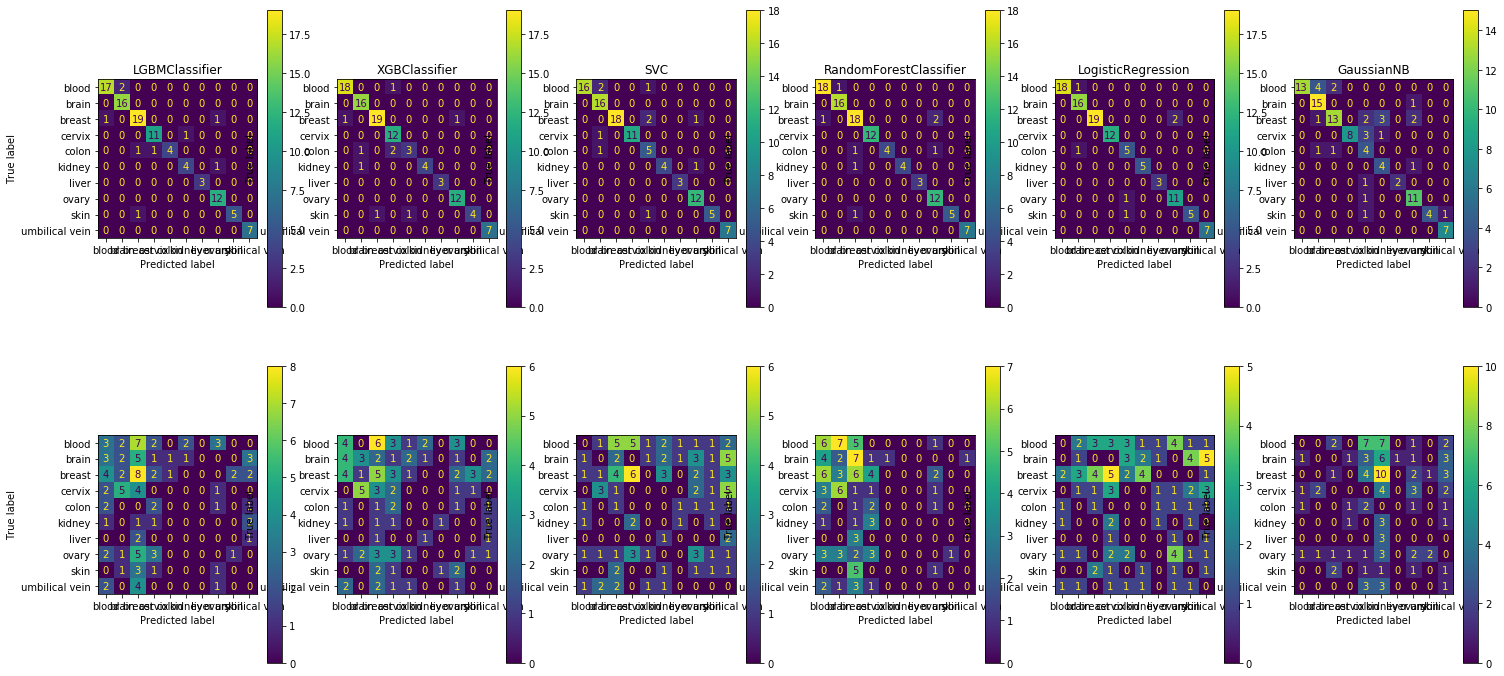

In [108]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.25, stratify=y)
X_train_shuffle, X_test_shuffle, y_train_shuffle, y_test_shuffle = train_test_split(df.sample(frac = 1, random_state = 1), y, test_size = 0.25, stratify=y)

all = len(y_train)
weights = {}
for label in range(10):
    weights[label] = all/(9*np.count_nonzero(y_train == label))

fig, ax = plt.subplots(2,6, figsize = (25,12))
for plot_column, model in enumerate(models):
    print(f"--------\n{type(model).__name__}")

    if type(model).__name__ not in ["XGBClassifier", "GaussianNB"]:
        model.set_params(**{'class_weight': weights})
    
    pipe = Pipeline(steps = [
        ("scaler", scaler),
        ("feature_selector", feature_selection),
        ("estimator", model)
    ])
    
    fitted_model = pipe.fit(X_train, y_train)
    y_pred = fitted_model.predict(X_test)

    shuffle_fitted_model = pipe.fit(X_train_shuffle, y_train_shuffle)
    y_pred_shuffle = shuffle_fitted_model.predict(X_test_shuffle)
    
    print("F1_micro {}           : {:.2f}".format(type(model).__name__, f1_score(y_test, y_pred, average = 'micro')))
    print("F1_micro {} (shuffled): {:.2f}\n".format(type(model).__name__, f1_score(y_test_shuffle, y_pred_shuffle, average = 'micro')))

    cm = confusion_matrix(y_test, y_pred)
    cm_shuffle = confusion_matrix(y_test_shuffle, y_pred_shuffle)

    cmp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_encoder.inverse_transform(pipe.classes_))
    cmp.plot(ax = ax[0, plot_column])
    cmp_shuffle = ConfusionMatrixDisplay(confusion_matrix = cm_shuffle, display_labels = target_encoder.inverse_transform(pipe.classes_))
    cmp_shuffle.plot(ax = ax[1, plot_column])

    ax[0, plot_column].set_title(type(model).__name__)

    

Selected 89 features.
Selected 93 features.
F1_micro VotingClassifier           : 0.94
F1_micro VotingClassifier (shuffled): 0.11



Text(0.5, 1.0, 'Ensemble model shuffled')

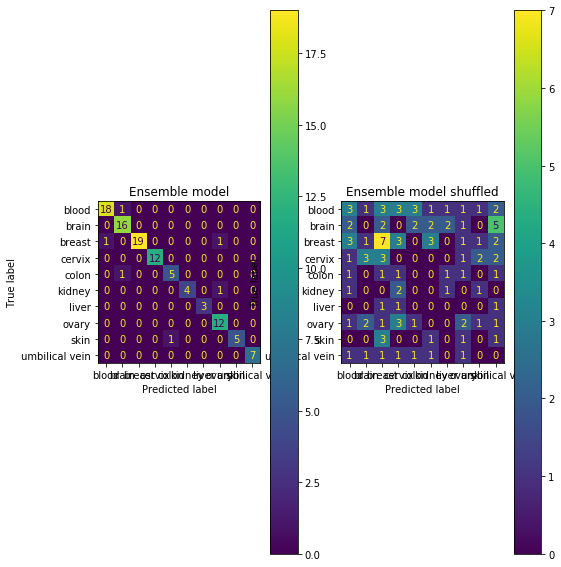

In [117]:
# Ensemble model with majority voting

ensemble_clf = VotingClassifier(estimators=[
       ('lgbm', lgbm(class_weight=weights)), 
       ("svc", SVC(class_weight = weights)),
       ("xgb", xgb_clf),
       ('lr', LogisticRegression(class_weight = weights, max_iter = 10000))], voting='hard',
       weights=[0.92,0.91,0.92,0.94])

pipe = Pipeline(steps = [
        ("scaler", scaler),
        ("feature_selector", feature_selection),
        ("estimator", ensemble_clf)
    ])

fig, ax = plt.subplots(1,2, figsize = (8,10))

fitted_model = pipe.fit(X_train, y_train)
y_pred = fitted_model.predict(X_test)

shuffle_fitted_model = pipe.fit(X_train_shuffle, y_train_shuffle)
y_pred_shuffle = shuffle_fitted_model.predict(X_test_shuffle)
    
print("F1_micro {}           : {:.2f}".format(type(ensemble_clf).__name__, f1_score(y_test, y_pred, average = 'micro')))
print("F1_micro {} (shuffled): {:.2f}\n".format(type(ensemble_clf).__name__, f1_score(y_test_shuffle, y_pred_shuffle, average = 'micro')))

cm = confusion_matrix(y_test, y_pred)
cm_shuffle = confusion_matrix(y_test_shuffle, y_pred_shuffle)

cmp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_encoder.inverse_transform(pipe.classes_))
cmp.plot(ax = ax[0])
cmp = ConfusionMatrixDisplay(confusion_matrix = cm_shuffle, display_labels = target_encoder.inverse_transform(pipe.classes_))
cmp.plot(ax = ax[1])

ax[0].set_title("Ensemble model")
ax[1].set_title("Ensemble model shuffled")

# Use interpretable Logistic Regression to investigate feature importance

In [120]:
all = len(y)
weights = {}
for label in range(10):
    weights[label] = all/(9*np.count_nonzero(y == label))

pipe = Pipeline(steps = [
    ('scaler', scaler),
    ("feature_selection", feature_selection),
    ("estimator", LogisticRegression(class_weight=weights, max_iter = 10000))
])

fitted_model = pipe.fit(df, y)

Selected 95 features.


In [152]:
feature_names = df.columns[fitted_model.steps[1][1].final_mask]
feature_importance_df = pd.DataFrame() 
for i, fi in enumerate(fitted_model.steps[2][1].coef_):
    label = target_encoder.inverse_transform([fitted_model.steps[2][1].classes_[i]])
    
    label_df =  pd.DataFrame({"feature_name": feature_names, "importance": fi, "class": [label[0]]*len(feature_names)})
    feature_importance_df = pd.concat([feature_importance_df,label_df], axis = 0, ignore_index = True)

In [153]:
feature_importance_df

,feature_name,importance,class
0,hsa04510,-0.683309,blood
1,hsa04512,-0.840096,blood
2,hsa05165,-0.638030,blood
3,hsa05200,-0.511153,blood
4,hsa00565,-0.132450,blood
...,...,...,...
945,hsa00130,-0.277325,umbilical vein
946,hsa00430,0.570803,umbilical vein
947,hsa00780,0.146489,umbilical vein
948,hsa00440,-0.346399,umbilical vein


In [171]:
top_20_index = feature_importance_df.importance.sort_values(ascending = False)[:20].index
top_20_f = feature_importance_df.loc[top_20_index, "feature_name"]
top_20_df = feature_importance_df[feature_importance_df.feature_name.isin(top_20_f)]

In [172]:
top_20_df["meta"] = top_20_df.feature_name.apply(lambda x: KEGG_MAP[KEGG_MAP.path == x].meta.unique()[0])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [173]:
top_20_df

,feature_name,importance,class,meta
11,hsa04974,-0.468903,blood,Protein digestion and absorption
19,hsa05150,-0.091544,blood,Staphylococcus aureus infection
20,hsa00140,-0.426616,blood,Steroid hormone biosynthesis
42,hsa04152,0.140399,blood,AMPK signaling pathway
44,hsa04725,0.225604,blood,Cholinergic synapse
...,...,...,...,...
941,hsa03260,-0.109882,umbilical vein,Virion
944,hsa03267,-0.286358,umbilical vein,Virion
946,hsa00430,0.570803,umbilical vein,Taurine and hypotaurine metabolism
947,hsa00780,0.146489,umbilical vein,Biotin metabolism


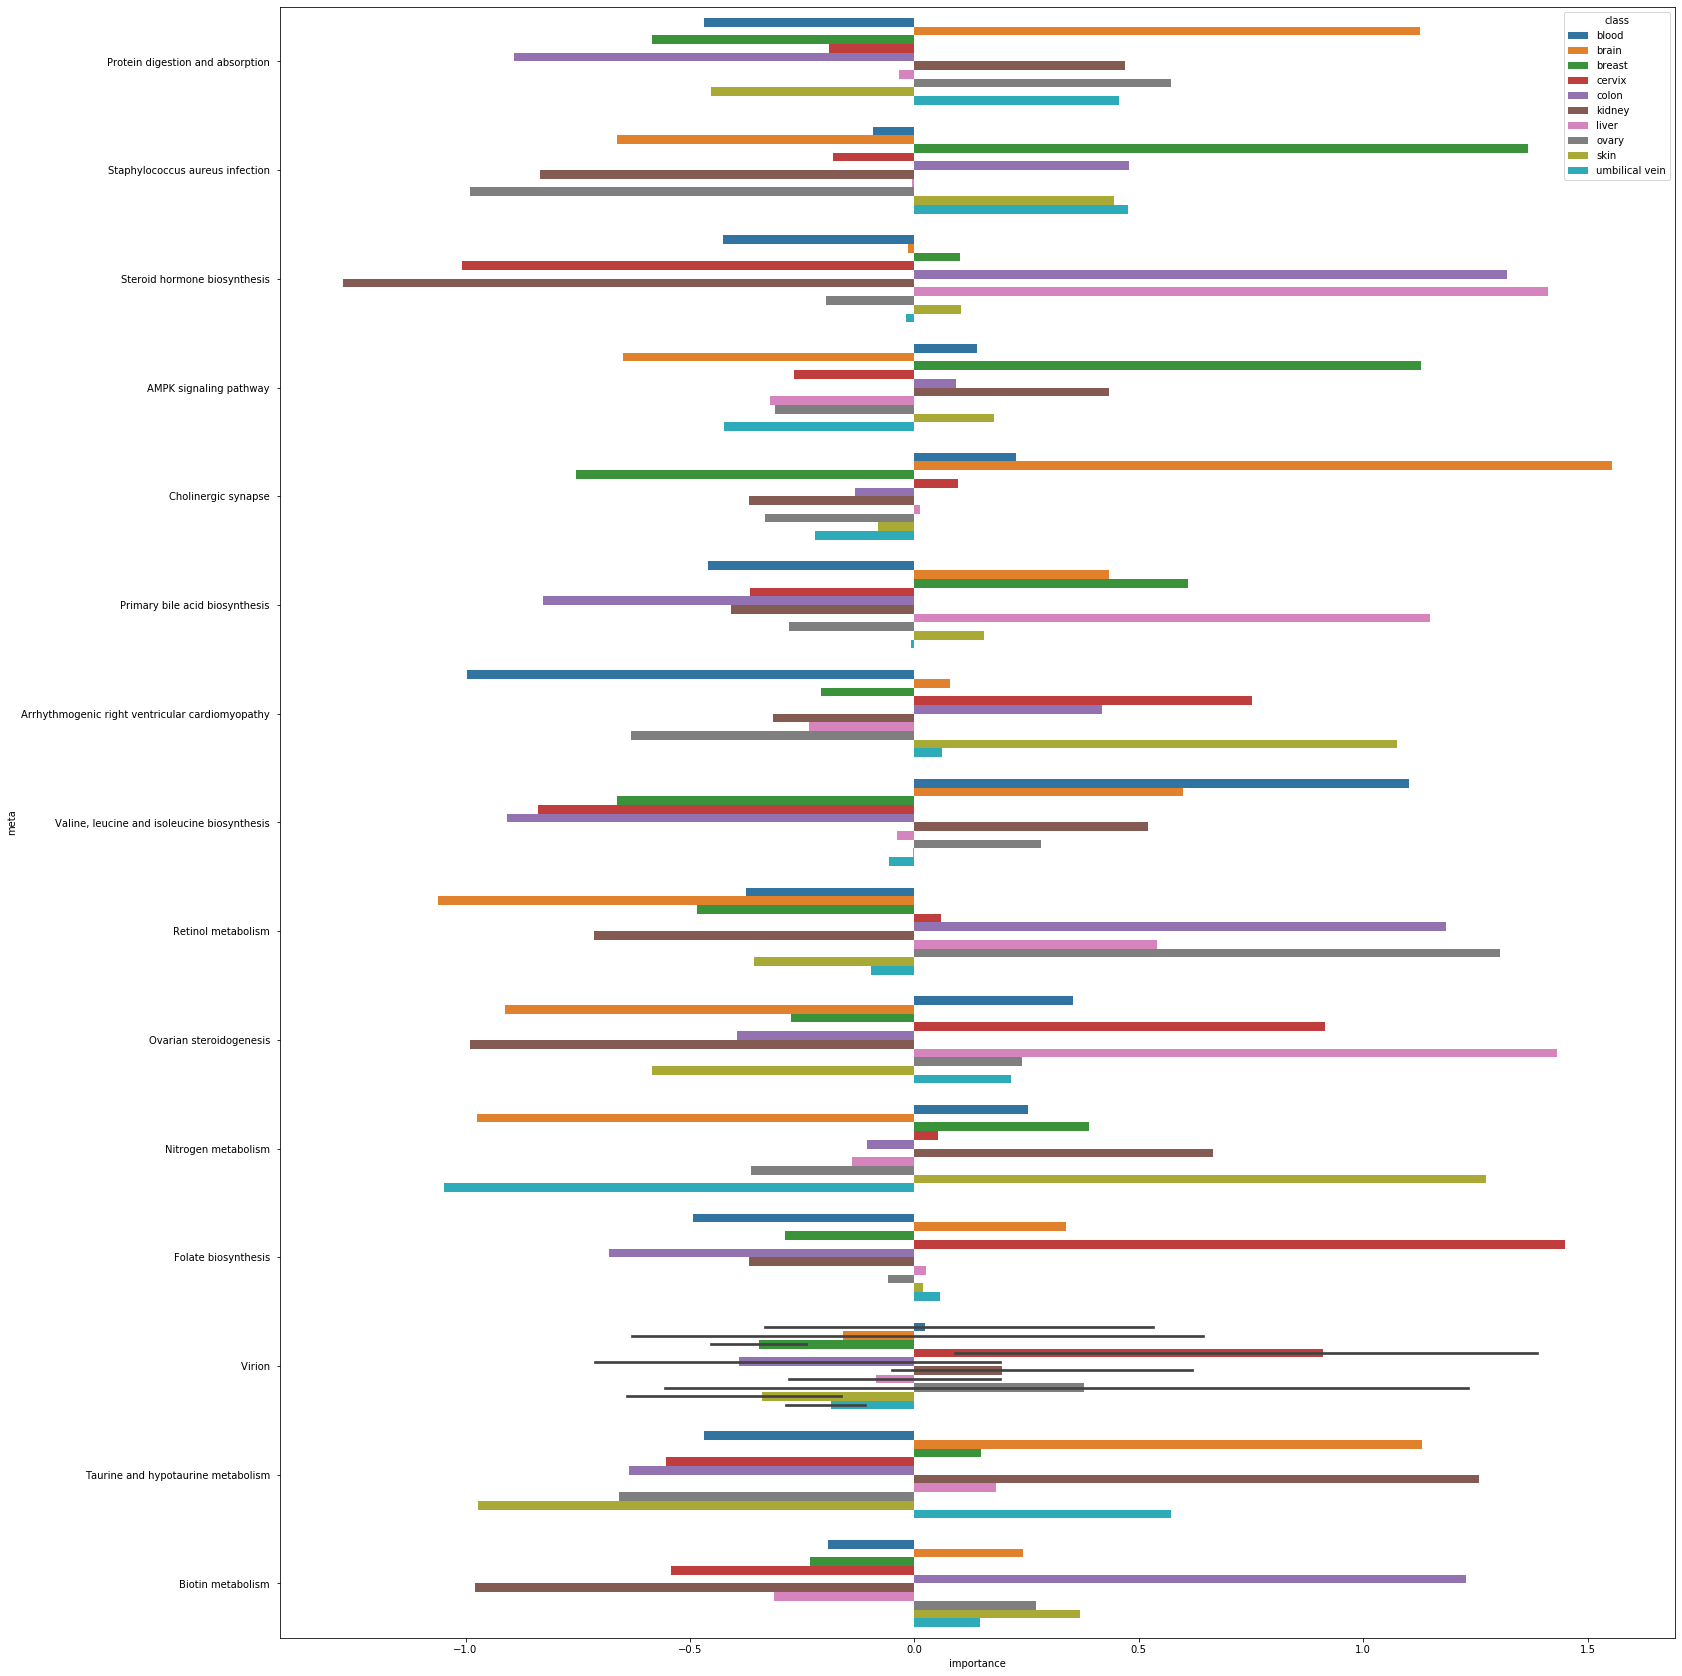

In [174]:
plt.figure(figsize = (25, 30))
sns.barplot(data = top_20_df, x = "importance", y = "meta", hue = "class")